# Tutorial: global_with_exf

### Written by M. Wood. June 2021

This verification experiment is almost identical to the global_with_exf experiment configured with the files in the `global_with_exf/input` directory, except that it uses `diagnostics_vec` to output variables from the model and compares them to variables from the `diagnostics` package to show that the two packages are identical.

The `global_with_exf` experiment provides a demonstration of a configuration that utilizes the `exf` package. In particular, the model implements a number of external forcing parameters including heat and salt fluxes, wind stress, and climatological sea surface temperature and salinity. Here, we demonstrate that the `diagnostics_vec` package can be used to output these variables from simulations in 2D surface grids.

This tutorial follows 5 steps:
1. Prepare the configuration
2. Prepare the diagnostic_vec masks
3. Build the model
4. Run the model
5. Compare diagnostics_vec vs diagnostics_output


### 1. Prepare the configuration
To prepare the configuration, `cd` to the `input_dv` directory within the `global_with_exf`  experiment. As for the code in the base experiment `input` directory, we provide a **prepare_run** script which can be used to generate all of the necessary files (aside from the few already provided). Run this from the command line, e.g.:

### 2. Prepare the diagnostics_vec masks

The diagnostics_vec masks are generated using a simple Python script, `create_masks.py`, which is additionally provided in the input_dv directory. Create the masks (from within the input_dv directory) by running the script:

This script creates five masks - four which laterally bound a subdomain in the pacific ocean, and one which covers the entire surface of the subdomain. To view these masks relative to the model bathymetry, we can read and plot them as follows:

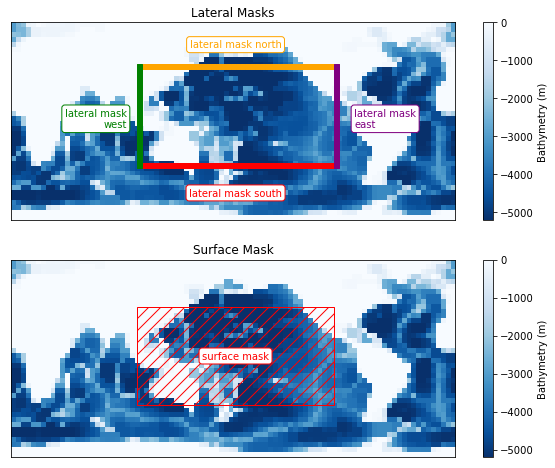

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# set the path to the input directory (UPDATE FOR YOUR SYSTEM)
input_dir = '../../../MITgcm/MITgcm_fresh/verification/global_with_exf/input_dv'

Nx = 90
Ny = 40

lateral_mask_names = ['lateral_mask_south','lateral_mask_north',
              'lateral_mask_west','lateral_mask_east']

# collect the mask files
lateral_mask_grids = []
for mask_name in lateral_mask_names:
    mask_file = os.path.join(input_dir,mask_name+'.bin')
    mask_grid = np.fromfile(mask_file,dtype='>f4')
    mask_grid = np.reshape(mask_grid,(Ny,Nx))
    lateral_mask_grids.append(mask_grid)
surface_mask_file = os.path.join(input_dir,'surface_mask.bin')
surface_mask_grid = np.fromfile(surface_mask_file,dtype='>f4')
surface_mask_grid = np.reshape(surface_mask_grid,(Ny,Nx))

# read the bathymetry
bathy_file = os.path.join(input_dir,'bathymetry.bin')
bathy_grid = np.fromfile(bathy_file,dtype='>f4')
bathy_grid = np.reshape(bathy_grid,(Ny,Nx))

# plot the masks on the bathymetry
fig = plt.figure(figsize=(10,8))
mask_plot_colors = ['red','orange','green','purple']

plt.subplot(2,1,1)
plt.title('Lateral Masks')
C = plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')
cbar = plt.colorbar(C)
cbar.set_label('Bathymetry (m)')
for mn in range(len(lateral_mask_grids)):
    rows,cols = np.where(lateral_mask_grids[mn]!=0)
    for pt in range(len(rows)):
        rect = Rectangle((cols[pt],rows[pt]),1,1,color=mask_plot_colors[mn])
        plt.gca().add_patch(rect)
plt.text(45,5,'lateral mask south',color=mask_plot_colors[0],ha='center',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[0],fc='w'))
plt.text(45,35,'lateral mask north',color=mask_plot_colors[1],ha='center',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[1],fc='w'))
plt.text(23,20,'lateral mask\nwest',color=mask_plot_colors[2],ha='right',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[2],fc='w'))
plt.text(69,20,'lateral mask\neast',color=mask_plot_colors[3],ha='left',va='center',
         bbox=dict(boxstyle="round",ec=mask_plot_colors[3],fc='w'))

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.subplot(2,1,2)
plt.title('Surface Mask')
C = plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')
cbar = plt.colorbar(C)
cbar.set_label('Bathymetry (m)')
rows,cols = np.where(surface_mask_grid!=0)
rect = Rectangle((np.min(cols),np.min(rows)),
                 np.max(cols)-np.min(cols),np.max(rows)-np.min(rows),
                 color='red',hatch='//',fill=False)
plt.gca().add_patch(rect)
plt.text(45,20,'surface mask',color='red',ha='center',va='center',
         bbox=dict(boxstyle="round",ec='red',fc='w'))

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.show()

### 3. Build the model
For this experiement, we provide options for configuring the model with and without MPI. Build the model according to your system specifications.

### 4. Run the model
With the model built, run it as you would on your system.

### 5. Compare Diagnostics_vec vs Standard Model Output

In [14]:
# set the path to the run directory (UPDATE FOR YOUR SYSTEM)
run_dir = '../../../MITgcm/MITgcm_fresh/verification/global_with_exf/run'

Nx = 90
Ny = 40
nTimesteps = 2160
Nr = 15

# extents of the masks (defined in input_dc/create_masks.py)
min_row = 10
max_row = 30
min_col= 25
max_col = 65

#### Compare the lateral boundaries 
First, we can compare the model output via diagnostics_vec with the standard model output on the "lateral masks" we defined:

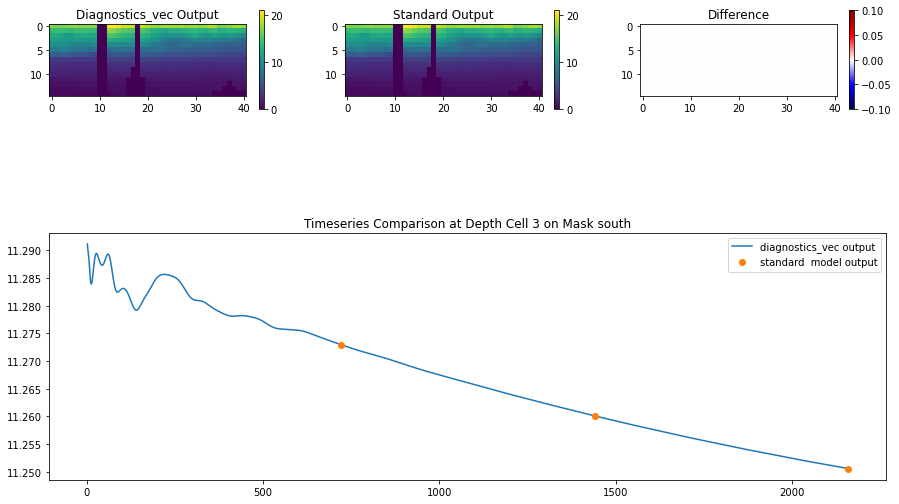

In [15]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'THETA' # THETA, SALT, UVEL, VVEL, or WVEL
mask_name = 'south' # north, south, east, or west
comparison_timestep = 720 #720, 1440, 2160
test_row = 5 # between 0 and 20 (=max_row - min_row)
test_col = 7 # between 0 and 40 (=max_col - min_col)
test_depth_level = 3

# read in the diagnostics_vec output
file_path = os.path.join(run_dir,'lateral_mask_'+mask_name+'_'+var_name+'.bin')
diag_vec_output = np.fromfile(file_path,'>f4')
if mask_name in ['north','south']:
    diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,Nr,max_col-min_col+1))
    diag_vec_timeseries = diag_vec_output[:,test_depth_level,test_col]
if mask_name in ['east','west']:
    diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,Nr,max_row-min_col+1))
    diag_vec_timeseries = diag_vec_output[:,test_depth_level,test_row]
diag_vec_comparison_field = diag_vec_output[comparison_timestep-1,:,:] #no IC's here

# read in the diagnostics output
file_prefix = os.path.join(run_dir,var_name[0])
standard_output = rdmds(file_prefix,[720,1440,2160])
standard_output_timestep = [720,1440,2160].index(comparison_timestep)

if mask_name=='north':
    standard_output_comparison_field = standard_output[standard_output_timestep,:,
                                                      max_row,min_col:max_col+1]
    standard_output_timeseries = standard_output[:,test_depth_level,max_row,min_col+test_col]
if mask_name=='south':
    standard_output_comparison_field = standard_output[standard_output_timestep,:,
                                                      min_row,min_col:max_col+1]
    standard_output_timeseries = standard_output[:,test_depth_level,min_row,min_col+test_col]
if mask_name in ['east']:
    standard_output_comparison_field = standard_output[standard_output_timestep,:,
                                                      min_row:max_row+1,max_col]
    standard_output_timeseries = standard_output[:,test_depth_level,min_row+test_row,max_col]
if mask_name in ['west']:
    standard_output_comparison_field = standard_output[standard_output_timestep,:,
                                                      min_row+test_row,min_col]
    standard_output_timeseries = standard_output[:,test_depth_level,min_row+test_row,min_col]
    
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
C = plt.imshow(diag_vec_comparison_field)
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')

plt.subplot(2,3,2)
C2 = plt.imshow(standard_output_comparison_field)
plt.colorbar(C2, shrink=0.4)
plt.title('Standard Output')

plt.subplot(2,3,3)
C3 = plt.imshow(diag_vec_comparison_field - standard_output_comparison_field,cmap='seismic')
plt.colorbar(C3, shrink=0.4)
plt.title('Difference')

plt.subplot(2,1,2)
plt.plot(np.arange(1,2161),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot(np.arange(720,2161,720),standard_output_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison at Depth Cell '+str(test_depth_level)+' on Mask '+mask_name)
plt.show()


#### Compare the surface (exf) variables
Next, we can compare the external forcing fielda as output from diagnosticsw_vec and diagnostics:

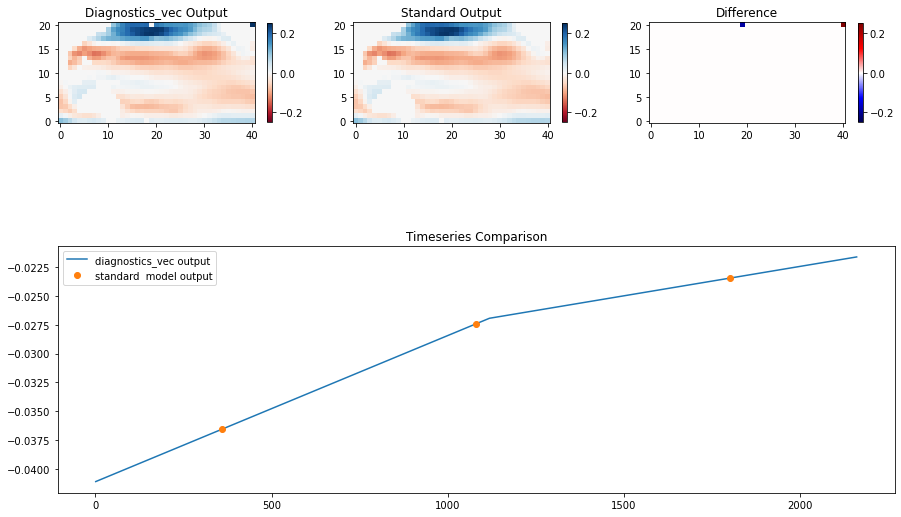

In [20]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'USTRESS' # THETA, SALT, UVEL, VVEL, or WVEL
comparison_timestep = 360 #360, 1080, or 1800
test_row = 15 # between 0 and 20 (=max_row - min_row)
test_col = 20 # between 0 and 40 (=max_col - min_col)

# read in the diagnostics_vec output
file_path = os.path.join(run_dir,'surface_mask_'+var_name+'.bin')
diag_vec_output = np.fromfile(file_path,'>f4')
diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,max_row-min_row+1,max_col-min_col+1))
diag_vec_timeseries = diag_vec_output[:,test_row,test_col]
diag_vec_comparison_field = diag_vec_output[360,:,:] #no IC's here

# # read in the diagnostics output
file_prefix = os.path.join(run_dir,'diagsEXF')
standard_output = rdmds(file_prefix,[360,1080,1800])
standard_output_timestep = [360,1080,1800].index(comparison_timestep)
var_index = ['USTRESS','VSTRESS','QNET','EMPMR'].index(var_name)
standard_output_comparison_field = standard_output[standard_output_timestep,var_index,
                                                   min_row:max_row+1,min_col:max_col+1]
standard_output_timeseries = standard_output[:,var_index,min_row+test_row,min_col+test_col]

# if mask_name=='north':
#     standard_output_comparison_field = standard_output[standard_output_timestep,:,
#                                                       max_row,min_col:max_col+1]
#     standard_output_timeseries = standard_output[:,test_depth_level,max_row,min_col+test_col]
# if mask_name=='south':
#     standard_output_comparison_field = standard_output[standard_output_timestep,:,
#                                                       min_row,min_col:max_col+1]
#     standard_output_timeseries = standard_output[:,test_depth_level,min_row,min_col+test_col]
# if mask_name in ['east']:
#     standard_output_comparison_field = standard_output[standard_output_timestep,:,
#                                                       min_row:max_row+1,max_col]
#     standard_output_timeseries = standard_output[:,test_depth_level,min_row+test_row,max_col]
# if mask_name in ['west']:
#     standard_output_comparison_field = standard_output[standard_output_timestep,:,
#                                                       min_row+test_row,min_col]
#     standard_output_timeseries = standard_output[:,test_depth_level,min_row+test_row,min_col]
    
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
C = plt.imshow(diag_vec_comparison_field,origin='lower',cmap='RdBu',vmin=-0.25,vmax=0.25)
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')

plt.subplot(2,3,2)
C2 = plt.imshow(standard_output_comparison_field,origin='lower',cmap='RdBu',vmin=-0.25,vmax=0.25)
plt.colorbar(C2, shrink=0.4)
plt.title('Standard Output')

plt.subplot(2,3,3)
C3 = plt.imshow(diag_vec_comparison_field - standard_output_comparison_field,origin='lower',
                cmap='seismic',vmin=-0.25,vmax=0.25)
plt.colorbar(C3, shrink=0.4)
plt.title('Difference')

plt.subplot(2,1,2)
plt.plot(np.arange(1,2161),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot([360,1080,1800],standard_output_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison')
plt.show()


861


Text(0.5, 1.0, 'Diagnostics_vec Output')

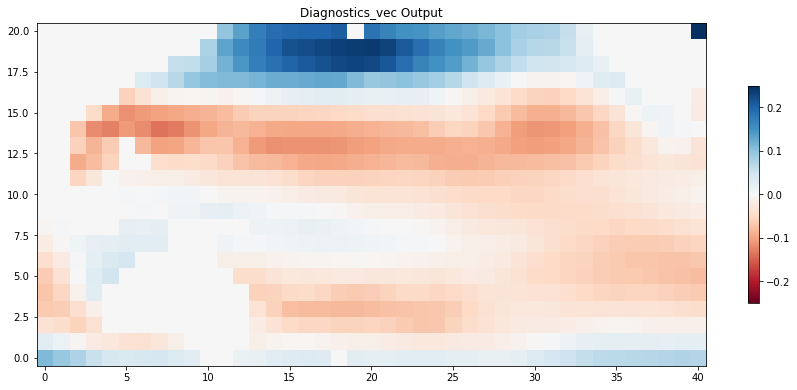

In [22]:
# set the path to the run directory (UPDATE FOR YOUR SYSTEM)
run_dir = '../../../MITgcm/MITgcm_fresh/verification/global_with_exf/run'

print(21*41)

# extents of the masks (defined in input_dc/create_masks.py)
min_row = 10
max_row = 30
min_col= 25
max_col = 65
nTimesteps = 2

# read in the diagnostics_vec output
file_path = os.path.join(run_dir,'surface_mask_USTRESS.bin')
diag_vec_output = np.fromfile(file_path,'>f4')
diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,max_row-min_row+1,max_col-min_col+1))
diag_vec_comparison_field = diag_vec_output[1,:,:]

plt.figure(figsize=(15,10))
C = plt.imshow(diag_vec_comparison_field,origin='lower',cmap='RdBu',vmin=-0.25,vmax=0.25)
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')